# Trying CNN 

In [1]:
import torch
import pandas as pd
import numpy as np
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import time

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm as tqdm
from IPython.display import clear_output

from Network import *
from TorchMalaria import *

import matplotlib.pyplot as plt
from skimage.transform import resize

torch.set_num_threads(2)

In [2]:
data = DataMalaria("list_of_imagenames_with_label.csv", transform=torchvision.transforms.ToTensor(), TTS = True)

In [3]:
data.trainmode()
batchsize = 200
trainloader = DataLoader(data, batch_size = batchsize, shuffle = True)
len(data)/batchsize

103.34

In [7]:
trainIter = iter(trainloader)

batch = next(trainIter)
images, labels = batch
if len(images) < 10:
    # make grid takes tensor as arg
    # tensor : (batchsize, channels, height, width)
    grid = torchvision.utils.make_grid(images)
    fig = plt.figure(figsize=(10, 80))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.title(labels.numpy())
    plt.show()

In [12]:
data.trainmode()
network = Network()
network.double()
network.load_state_dict(torch.load("NetworkModel.pt"))
optimizer = optim.Adam(network.parameters(), lr = 0.005)

nEpochs = 3


for epoch in range(nEpochs):
    totalLoss = 0
    totalCorrect = 0
    counter = 0
    t = time.time()
    
    for batch in trainloader:
        images, labels = batch
        
        # forward pass + calculate loss
        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        # PyTorch telt alle gradienten op. Daarom moet de gradient gereset worden.
        optimizer.zero_grad()

        # backward propagation + updating weights
        loss.backward()
        optimizer.step()

        totalLoss += loss.item()
        totalCorrect += GetNumCorrect(preds, labels)
        clear_output()
        counter += len(labels)
        print("{}/{}".format(counter, len(data)))
        print("epoch: {}\nTotalCorrect: {}\nTotalLoss: {}\n\nTime: {:3.1f}s\nAccuracy: {}\n\n".format(epoch, totalCorrect, totalLoss, time.time() - t, totalCorrect.item() / counter))


20668/20668
epoch: 2
TotalCorrect: 19391
TotalLoss: 19.751549551669633

Time: 329.7s
Accuracy: 0.9382136636346042




In [27]:
torch.save(network.state_dict(), "NetworkModel.pt")

In [4]:
network1 = Network()
network1.double()
network1.load_state_dict(torch.load("NetworkModel.pt"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [5]:
data.testmode()
testloader = DataLoader(data, batch_size = batchsize, shuffle = True)

In [13]:
batch = next(iter(testloader))
from sklearn.metrics import confusion_matrix
confmat = np.zeros((2, 2))

counter = 0
totalCorrect = 0 
for batch in testloader:
    images, labels = batch

    # forward pass + calculate loss
    preds = network1(images)
    confmat += confusion_matrix(labels, preds.argmax(dim = 1).numpy())
    clear_output()
    counter += len(labels)
    totalCorrect += GetNumCorrect(preds, labels)
    print("{}/{}".format(counter, len(data)))
    print("{:4.0f}|{:4.0f}\n{:4.0f}|{:4.0f}".format(confmat[0, 0], confmat[0, 1], confmat[1, 0], confmat[1, 1]))
    print("Accuracy: {:2.1f}".format(totalCorrect.item()/counter * 100))

6890/6890
3372| 108
 206|3204
Accuracy: 95.4


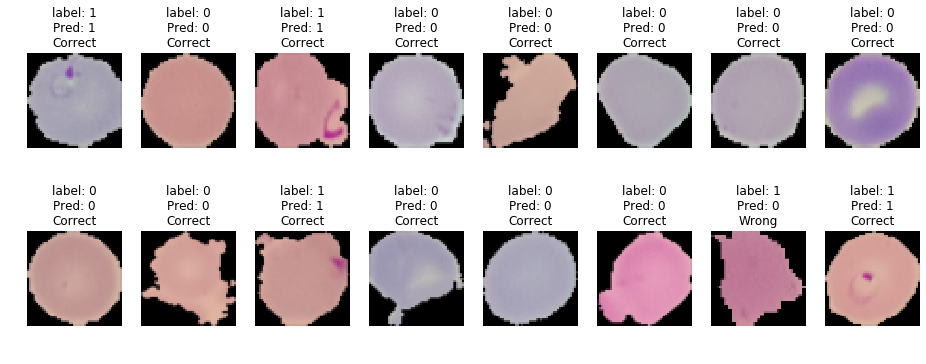

In [35]:
fig, axes = plt.subplots(2, 8, sharey = True)
fig.set_size_inches(16, 6)
ind = np.random.randint(len(data), size = 16)
counter = 0
for rowAx in axes:
    for ax in rowAx:
        ax.axis("off")
        image, label = data[ind[counter]]
        out = network1(image.unsqueeze(0))
        pred = out.argmax(dim = 1).numpy()[0]
        data.imshowsingle(ind[counter], ax)
        if label == pred:
            resultText = "Correct"
        else:
            resultText = "Wrong"
        ax.title.set_text("label: {}\nPred: {}\n{}".format(label, pred, resultText))
        
            
        ax.set_xlabel(resultText)
        counter += 1
plt.show()

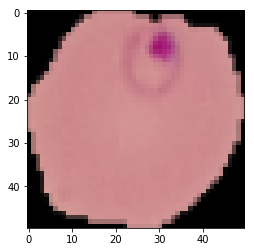

In [11]:
image, label = data[1]
plt.imshow(torch.transpose(image, -3, 2))

In [26]:
print(" Bright Green  \n")

 Bright Green  

